# Exploración inicial de los datos

In [12]:
import os
import random

from tqdm import tqdm 

import matplotlib.pyplot as plt
from skimage import io #Para leer las imágenes
from skimage import img_as_float

%matplotlib inline

Nota: El módulo tqdm muestra una barra de progreso durante los ciclos, sólo la uso por que se ve chévere.

## Definición de directorios

In [3]:
ROOT_DIR = os.getcwd()
DATA_DIR = os.path.join(ROOT_DIR, 'german-traffic-signs')
TRAIN_DIR = os.path.join(DATA_DIR, 'training-set')
TEST_DIR = os.path.join(DATA_DIR, 'test-set')

In [4]:
os.path.split(ROOT_DIR)

('C:\\Users\\srodri16\\Desktop', 'supervised-avanzado-german-traffic-signs')

In [5]:
assert os.path.exists(DATA_DIR)
assert os.path.exists(TRAIN_DIR)
assert os.path.exists(TEST_DIR)

## Imágenes por clase en datos de entrenamiento

Vale la pena conocer si los datos se encuentran balanceados o no (probablemente no) ya que esto puede afectar la estrategia a emplear.

In [6]:
def plot_images_per_class(path): 
    lista  = [(int(folder), len(os.listdir(os.path.join(path,folder))) - 1) for folder in os.listdir(path)]
    lista = sorted(lista, key = lambda x: x[0])
    xVals = [clase for clase, val in lista]
    yVals = [val for clase, val in lista]
    fig = plt.figure(figsize=[15,5])
    ax = fig.add_subplot(111)
    plt.bar(xVals,yVals,width = 0.5)
    ax.set_title('Number of pictures per class', color = 'k', alpha = 0.6)
    ax.set_xlabel('Class', fontsize = 14)
    ax.set_ylabel('Number of pictures', fontsize = 14)
    ax.set_axisbelow(True)

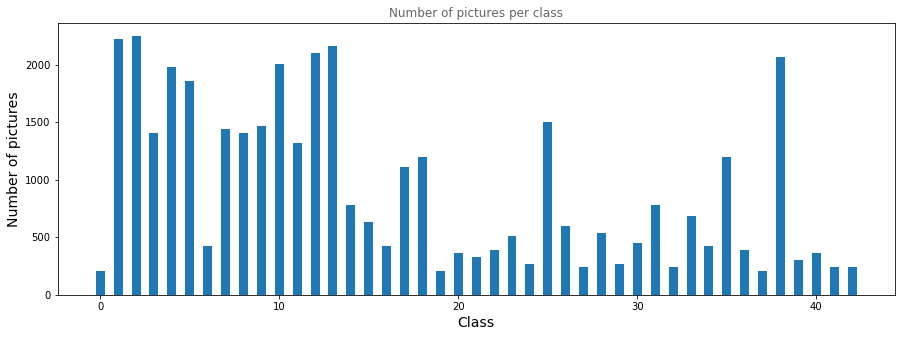

In [7]:
plot_images_per_class(TRAIN_DIR)

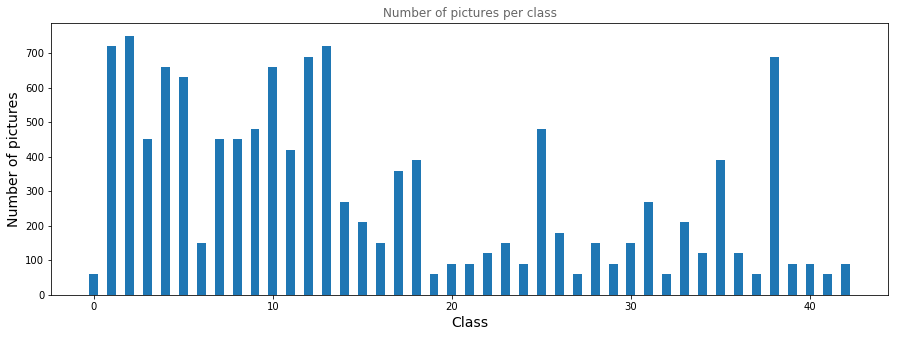

In [8]:
plot_images_per_class(TEST_DIR)

## Observar algunas de las imágenes

Con esta función podemos ver algunas de las imágenes, también se puede ver que el resultado de aplicar un escalamiento sencillo no altera la imagen final. Este escalamiento puede ser muy útil para la convergencia de algunos algoritmos.

In [9]:
def plot_random_sample(path,n_fos = 5,n_im = 3, scale = True, values = False):
    hor = n_fos
    ver = min(n_fos,n_im)
    fos = random.sample(os.listdir(path), n_fos)
    lista = []
    for fo in tqdm(fos):
        lista.append([os.path.join(fo,fi) for fi in random.sample(os.listdir(os.path.join(path,fo)),n_im) if fi.endswith('.jpg')])
    new_style = {'grid': False}
    plt.rc('axes', **new_style)
    _, ax = plt.subplots(n_fos, n_im, sharex='col', sharey='row', figsize=(2*n_im, 2*n_fos))
    for i, files in enumerate(lista):
        for j, file in enumerate(files):
            if scale:
                img = img_as_float(io.imread(os.path.join(path,file)))
            else:
                img = io.imread(os.path.join(path,file))
            if values:
                print(img)
            ax[i, j].imshow(img)
            ax[i, j].set_title(file)
    plt.show()

100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 131.58it/s]


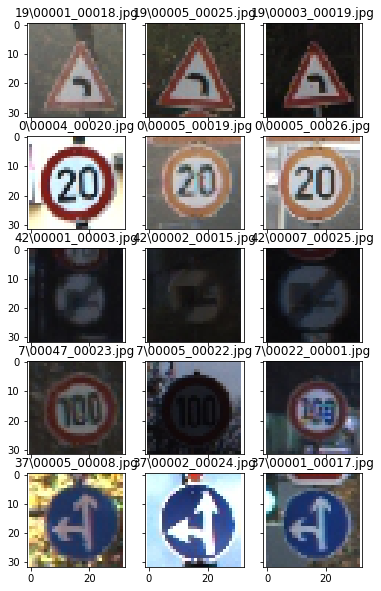

In [11]:
plot_random_sample(TRAIN_DIR)

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 1000.02it/s]


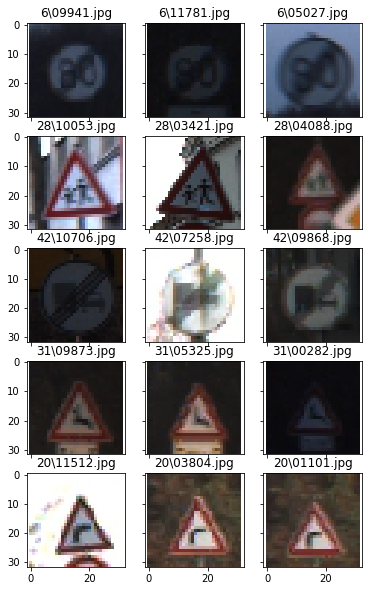

In [10]:
plot_random_sample(TEST_DIR)

## Análisis de componentes principales (PCA)

In [21]:
from sklearn.decomposition import PCA, IncrementalPCA
import numpy as np

In [15]:
def load_data(files, scale = True):
    X, y = [], []
    for file in tqdm(files):
        if file.endswith(".jpg"):
            y.append(int(os.path.split(os.path.split(file)[0])[-1]))
            if scale:
                X.append(img_as_float(io.imread(file)))
            else:
                X.append(io.imread(file))
            
    return np.array(X), np.array(y)

def get_files_path(path, ext = ".jpg", n = np.inf):
    file_paths = []
    for folder in tqdm(os.listdir(path)):
        files = os.listdir(os.path.join(path,folder))
        if len(files) <= n:
            file_paths += [os.path.join(path,folder,file) for file in files if file.endswith(ext)]
        else:
            file_paths += [os.path.join(path,folder, file) for file in random.sample(files,n) if file.endswith(ext)]
            
    return file_paths

In [16]:
train_files = get_files_path(TRAIN_DIR)

100%|██████████████████████████████████████████| 43/43 [00:12<00:00,  3.58it/s]


In [17]:
X, y = load_data(train_files)
print(X.shape)
print(y.shape)

100%|████████████████████████████████████| 39209/39209 [07:56<00:00, 82.34it/s]


(39209, 32, 32, 3)
(39209,)


In [19]:
X = np.reshape(X, newshape = (-1,32*32*3))
print(X.shape)

(39209, 3072)


In [22]:
ipca = IncrementalPCA()
ipca.fit(X)

IncrementalPCA(batch_size=None, copy=True, n_components=None, whiten=False)

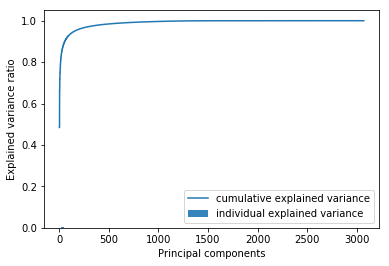

In [26]:
plt.step(range(1,len(ipca.explained_variance_ratio_)+1), np.cumsum(ipca.explained_variance_ratio_), where='mid',
         label='cumulative explained variance')
plt.bar(range(1,len(ipca.explained_variance_ratio_)+1), ipca.explained_variance_ratio_, alpha=0.9, align='center',
        label='individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()

Se puede ver que muy pocos pixeles contribuyen a la variabilidad de de los datos.